# Introduction

This is my Capstone project that attempts to answer the question "how can historical pharmacy claims data be used to accurately forecast a health plan group's drug spend over the next 12-24 months, accounting for utilization patterns, price changes, and member dynamics?". This is a Python data science project that uses historical pharmacy claims data to forecast drug spend. Answering this question will help health plan groups budget for future expenditures and assist in setting more accurate financial guarantees.

## Description of the dataset

The dataset in question is two years of pharmacy claims history. The dataset contains the following data:
  - Claims-level transaction details
  - Drug information (NDC, quantity, days supply, cost)
  - Temporal features (fill dates, claim processing dates)

The actual dataset is found by executing the SQL command shown below.

```sql
-- This query will give you a complete view of drug spend metrics for all health plans in 2023 and 2024,
-- with proper formatting of dates and clear identification of each plan through the concatenated ID.
WITH monthly_claims AS (
    SELECT
        customer_id || '_' || client_id || '_' || client_group_id AS health_plan_id,
        cardholder_id,
        person_code,
        date_trunc('month', to_date(date_filled::text, 'YYYYMMDD'))::date as claim_month,
        COUNT(*) as claim_count,
        SUM(total_amount_due + approved_copay) as total_drug_spend,
        SUM(total_amount_due) as plan_paid_amount,
        SUM(approved_copay) as patient_paid_amount,
        SUM(days_supply) as total_days_supply,
        SUM(metric_dec_quantity) as total_quantity,
        COUNT(DISTINCT ndc) as unique_drugs
    FROM master.rh_rx_transaction_detail
    WHERE date_submitted BETWEEN 20230101 AND 20241231
        AND transaction_status = 'P'
    GROUP BY 1, 2, 3, 4
),
-- Generate month series for the analysis period
month_series AS (
    SELECT generate_series(
        '2023-01-01'::date,
        '2024-12-31'::date,
        '1 month'::interval
    )::date as month_date
),
-- Expand eligibility to monthly records
monthly_eligibility AS (
    SELECT DISTINCT
        ec.customer_code || '_' || ec.client_code || '_' || ec.group_code AS health_plan_id,
        ec.member_id as cardholder_id,
        ec.person_code,
        ms.month_date as eligibility_month,
        -- Calculate age as of each month
        (EXTRACT(YEAR FROM age(ms.month_date, ec.birth_date::date)) * 12 +
         EXTRACT(MONTH FROM age(ms.month_date, ec.birth_date::date)))::int / 12 as age_as_of_month,
        ec.gender,
        ec.zip_code,
        ec.effective_date,
        ec.termination_date
    FROM master.elig_cache ec
    CROSS JOIN month_series ms
    WHERE ec.effective_date <= ms.month_date
        AND ec.termination_date >= ms.month_date
),
-- Combine claims and eligibility
combined_monthly_data AS (
    SELECT
        e.health_plan_id,
        e.eligibility_month as month_date,
        -- Member Demographics
        COUNT(DISTINCT e.cardholder_id || e.person_code) as total_eligible_members,
        CEILING(AVG(e.age_as_of_month)) as avg_member_age,
        COUNT(DISTINCT CASE WHEN e.age_as_of_month >= 65 THEN e.cardholder_id || e.person_code END) as medicare_aged_members,
        -- Utilization Metrics
        COUNT(DISTINCT c.cardholder_id || c.person_code) as utilizing_members,
        COALESCE(SUM(c.claim_count), 0) as total_claims,
        COALESCE(SUM(c.unique_drugs), 0) as total_unique_drugs,
        COALESCE(SUM(c.total_days_supply), 0) as total_days_supply,
        COALESCE(SUM(c.total_quantity), 0) as total_quantity,
        -- Financial Metrics
        COALESCE(SUM(c.total_drug_spend), 0) as total_drug_spend,
        COALESCE(SUM(c.plan_paid_amount), 0) as plan_paid_amount,
        COALESCE(SUM(c.patient_paid_amount), 0) as patient_paid_amount,
        -- Calculated Metrics
        CASE
            WHEN COUNT(DISTINCT e.cardholder_id || e.person_code) > 0
            THEN ROUND((COUNT(DISTINCT c.cardholder_id || c.person_code)::float /
                 COUNT(DISTINCT e.cardholder_id || e.person_code))::NUMERIC, 2)
        END as utilization_rate,
        CASE
            WHEN COUNT(DISTINCT e.cardholder_id || e.person_code) > 0
            THEN ROUND(COALESCE(SUM(c.total_drug_spend) /
                 COUNT(DISTINCT e.cardholder_id || e.person_code), 0)::NUMERIC, 2)
        END as pmpm_total_spend,
        -- Member Changes
        COUNT(DISTINCT CASE
            WHEN e.effective_date >= e.eligibility_month AND
                 e.effective_date < e.eligibility_month + interval '1 month'
            THEN e.cardholder_id || e.person_code
        END) as new_members,
        COUNT(DISTINCT CASE
            WHEN e.termination_date >= e.eligibility_month AND
                 e.termination_date < e.eligibility_month + interval '1 month'
            THEN e.cardholder_id || e.person_code
        END) as termed_members,
        -- Demographic breakdowns
        COUNT(DISTINCT CASE WHEN e.gender = 'M' THEN e.cardholder_id || e.person_code END) as male_members,
        COUNT(DISTINCT CASE WHEN e.gender = 'F' THEN e.cardholder_id || e.person_code END) as female_members,
        COUNT(DISTINCT CASE WHEN e.age_as_of_month < 18 THEN e.cardholder_id || e.person_code END) as pediatric_members,
        COUNT(DISTINCT CASE WHEN e.age_as_of_month >= 18 AND e.age_as_of_month < 65 THEN e.cardholder_id || e.person_code END) as adult_members,
        COUNT(DISTINCT e.zip_code) as unique_zip_codes
    FROM monthly_eligibility e
    LEFT JOIN monthly_claims c
        ON e.health_plan_id = c.health_plan_id
            AND e.cardholder_id = c.cardholder_id
            AND e.person_code = c.person_code
            AND e.eligibility_month = c.claim_month
    GROUP BY 1, 2
)
SELECT
    *,
    -- Calculate total PMPM across all months
    ROUND(COALESCE(AVG(pmpm_total_spend) OVER (
        PARTITION BY health_plan_id
    ), 0), 2) as total_pmpm_all_months,
    -- Add rolling metrics
    ROUND(COALESCE(AVG(total_drug_spend) OVER (
        PARTITION BY health_plan_id
        ORDER BY month_date
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ), 0), 2) as rolling_3month_spend,
    ROUND(COALESCE(AVG(pmpm_total_spend) OVER (
        PARTITION BY health_plan_id
        ORDER BY month_date
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ), 0), 2) as rolling_3month_pmpm,
    -- Year over year calculations
    COALESCE(LAG(total_drug_spend, 12) OVER (
        PARTITION BY health_plan_id
        ORDER BY month_date
    ), 0) as prior_year_spend,
    COALESCE(LAG(utilizing_members, 12) OVER (
        PARTITION BY health_plan_id
        ORDER BY month_date
    ), 0) as prior_year_utilizing_members,
    -- Calculate month-over-month changes
    COALESCE(total_drug_spend - LAG(total_drug_spend, 1) OVER (
        PARTITION BY health_plan_id
        ORDER BY month_date
    ), 0) as mom_spend_change,
    ROUND((COALESCE((total_eligible_members - LAG(total_eligible_members, 1) OVER (
        PARTITION BY health_plan_id
        ORDER BY month_date
    ))::float / NULLIF(LAG(total_eligible_members, 1) OVER (
        PARTITION BY health_plan_id
        ORDER BY month_date
    ), 0) * 100, 0))::numeric, 1) as mom_membership_change_pct
FROM combined_monthly_data
ORDER BY health_plan_id, month_date;
```

This dataset provides a strong foundation for forecasting health plan drug spend because it combines several critical elements:

Financial Metrics:
- Total drug spend
- Plan paid amounts
- Member paid amounts
- PMPM metrics
- Rolling averages and trends

Population Dynamics:
- Total eligible members vs utilizing members
- Member turnover (new/termed)
- Age and gender distributions
- Geographic distribution via zip codes
- Utilization rates

Utilization Patterns:
- Claims per member
- Unique drugs per member
- Days supply
- Quantities dispensed

Trend Indicators:
- Year-over-year comparisons
- Rolling 3-month averages
- Month-over-month changes
- Seasonality patterns

This comprehensive dataset would allow you to:
- Build baseline forecasts using historical trends
- Adjust for population changes
- Account for seasonality
- Consider demographic shifts
- Factor in utilization pattern changes

The structure of the dataset loaded into a Pandas datafram is as follows:

```plaintext
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27702 entries, 0 to 27701
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   health_plan_id                27702 non-null  object
 1   month_date                    27702 non-null  object
 2   total_eligible_members        27702 non-null  int64
 3   avg_member_age                27702 non-null  int64
 4   medicare_aged_members         27702 non-null  int64
 5   utilizing_members             27702 non-null  int64
 6   total_claims                  27702 non-null  int64
 7   total_unique_drugs            27702 non-null  int64
 8   total_days_supply             27702 non-null  int64
 9   total_quantity                27702 non-null  float64
 10  total_drug_spend              27702 non-null  float64
 11  plan_paid_amount              27702 non-null  float64
 12  patient_paid_amount           27702 non-null  float64
 13  utilization_rate              27702 non-null  float64
 14  pmpm_total_spend              27702 non-null  float64
 15  new_members                   27702 non-null  int64
 16  termed_members                27702 non-null  int64
 17  male_members                  27702 non-null  int64
 18  female_members                27702 non-null  int64
 19  pediatric_members             27702 non-null  int64
 20  adult_members                 27702 non-null  int64
 21  unique_zip_codes              27702 non-null  int64
 22  total_pmpm_all_months         27702 non-null  float64
 23  rolling_3month_spend          27702 non-null  float64
 24  rolling_3month_pmpm           27702 non-null  float64
 25  prior_year_spend              27702 non-null  float64
 26  prior_year_utilizing_members  27702 non-null  int64
 27  mom_spend_change              27702 non-null  float64
 28  mom_membership_change_pct     27702 non-null  float64
dtypes: float64(12), int64(15), object(2)
```

## Description of the approach

The code implements a `DrugSpendForecast` class that provides a comprehensive framework for predicting and analyzing drug spend using either Random Forest or LightGBM models. Here's a breakdown of the key components and functions:

Core Model Functions:
- `__init__`: Initializes the forecaster with a choice between Random Forest or LightGBM models
- `_get_model`: Helper function that returns the configured model instance
- `train_model`: Handles feature selection, data splitting, scaling, model training, and stores feature importance results

Visualization Functions:
- `plot_actual_vs_predicted_low_spend`: Visualizes predictions for drug spend ≤ $500,000
- `plot_actual_vs_predicted_high_spend`: Visualizes predictions for drug spend > $500,000
- `plot_feature_importance`: Shows top 10 most important features with percentage contributions
- `plot_residuals_distribution`: Displays distribution of prediction errors using box plots
- `plot_residuals_by_actual`: Shows how prediction errors vary with actual spend
- `plot_prediction_intervals`: Creates 80% prediction intervals using gradient boosting

Analysis Functions:
- `get_detailed_metrics`: Calculates comprehensive performance metrics including:
  - Overall metrics (MAE, RMSE, R²)
  - Metrics by spend tier (low/medium/high)
  - Bias metrics (mean bias, % over-predicted)
- `compare_models`: Static method that compares Random Forest vs LightGBM performance
- `plot_model_comparison`: Creates 4 comparison visualizations:
  - Actual vs predicted scatter plots
  - Feature importance comparison
  - Residuals distribution comparison
  - Error metrics comparison

The approach focuses on:
- Robust model evaluation through multiple metrics and visualizations
- Separate handling of low vs high spend predictions
- Feature importance analysis to understand key drivers
- Model comparison to select the best performer
- Uncertainty quantification through prediction intervals
- Detailed error analysis through residual plots
- Bias detection in different spend tiers

This implementation provides a thorough framework for not just predicting drug spend, but also understanding model performance, identifying important features, and quantifying prediction uncertainty.

## Expected results

The expected results are as follows:
  - A predictive model forecasting drug spend with confidence intervals
  - Identification of key spending drivers through feature importance analysis
  - Specific forecasts breaking down:
    - Changes in utilization (quantity/days supply)
    - Impact of price changes
    - Member population dynamics (new/terminated users)
  - Performance metrics (MAPE, R-squared, or something else)
  - Visualization dashboard for monitoring

The goal now is to outline and implement specific forecasting approaches that could be used with this dataset using Python and any needed libraries so I end up with a working model that can be used to forecast drug spend.


In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

class DrugSpendForecast:
    """A class for forecasting drug spend using either Random Forest or LightGBM models."""

    VALID_MODELS = ['random_forest', 'lightgbm']

    def __init__(self, df, model_type='random_forest'):
        """
        Initialize the forecaster.
        Args:
            df (pandas.DataFrame): Input DataFrame
            model_type (str): Type of model to use ('random_forest' or 'lightgbm')
        """
        if model_type not in self.VALID_MODELS:
            raise ValueError(f"model_type must be one of {self.VALID_MODELS}")

        self.df = df.copy()
        self.df['month_date'] = pd.to_datetime(self.df['month_date'])
        self.model_type = model_type

    def _get_model(self):
        """Get the appropriate model based on model_type."""
        if self.model_type == 'random_forest':
            return RandomForestRegressor(n_estimators=100, random_state=42)
        else:  # lightgbm
            return LGBMRegressor(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=-1,
                random_state=42,
                verbose=-1  # Suppress output messages
            )

    def train_model(self):
        """Train the selected model on the data."""
        feature_columns = [
            # Member demographics and counts
            'total_eligible_members',
            'avg_member_age',
            'medicare_aged_members',
            'utilizing_members',
            'male_members',
            'female_members',
            'pediatric_members',
            'adult_members',

            # Utilization metrics
            'total_claims',
            'total_unique_drugs',
            'total_days_supply',
            'total_quantity',
            'utilization_rate',
            'unique_zip_codes',

            # Financial metrics and trends
            'pmpm_total_spend',
            'total_pmpm_all_months',
            'rolling_3month_spend',
            'rolling_3month_pmpm',
            'prior_year_spend',
            'prior_year_utilizing_members',

            # Population dynamics
            'new_members',
            'termed_members',
            'mom_spend_change',
            'mom_membership_change_pct'
        ]

        X = self.df[feature_columns]
        y = self.df['total_drug_spend']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Get and train model
        self.model = self._get_model()
        self.model.fit(X_train_scaled, y_train)

        # Make predictions
        self.y_pred = self.model.predict(X_test_scaled)
        self.y_test = y_test

        # Store feature importance
        self.feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        return self.model

    def plot_actual_vs_predicted_low_spend(self):
        """Plot actual vs predicted for drug spend ≤ $500,000"""
        plt.figure(figsize=(10, 6))

        # Filter for low spend
        threshold = 500000
        mask_low = self.y_test <= threshold

        # Create scatter plot
        plt.scatter(self.y_test[mask_low], self.y_pred[mask_low],
                    alpha=0.5, label='Predictions')

        # Add reference line
        min_val = min(self.y_test[mask_low].min(), self.y_pred[mask_low].min())
        max_val = max(self.y_test[mask_low].max(), self.y_pred[mask_low].max())
        plt.plot([min_val, max_val], [min_val, max_val],
                'r--', lw=2, label='Perfect Prediction')

        # Format axes
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        plt.xlabel('Actual Drug Spend')
        plt.ylabel('Predicted Drug Spend')
        plt.title(f'Actual vs Predicted Drug Spend (≤ $500,000)\nModel: {self.model_type}')
        plt.legend()
        plt.tight_layout()
        return plt

    def plot_actual_vs_predicted_high_spend(self):
        """Plot actual vs predicted for drug spend > $500,000"""
        plt.figure(figsize=(10, 6))

        # Filter for high spend
        threshold = 500000
        mask_high = self.y_test > threshold

        # Create scatter plot
        plt.scatter(self.y_test[mask_high], self.y_pred[mask_high],
                    alpha=0.5, label='Predictions')

        # Add reference line
        min_val = min(self.y_test[mask_high].min(), self.y_pred[mask_high].min())
        max_val = max(self.y_test[mask_high].max(), self.y_pred[mask_high].max())
        plt.plot([min_val, max_val], [min_val, max_val],
                'r--', lw=2, label='Perfect Prediction')

        # Format axes
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        plt.xlabel('Actual Drug Spend')
        plt.ylabel('Predicted Drug Spend')
        plt.title(f'Actual vs Predicted Drug Spend (> $500,000)\nModel: {self.model_type}')
        plt.legend()
        plt.tight_layout()
        return plt

    def plot_feature_importance(self):
        """Plot feature importance"""
        plt.figure(figsize=(10, 6))

        # Normalize feature importance to sum to 100%
        importance_df = self.feature_importance.copy()
        importance_df['importance'] = (importance_df['importance'] / importance_df['importance'].sum()) * 100

        # Create color palette for the number of features we'll show and convert to list
        colors = plt.cm.Set3(np.linspace(0, 1, 10)).tolist()

        # Create bar plot with different colors
        ax = sns.barplot(data=importance_df.head(10),
                        x='importance',
                        y='feature',
                        hue='feature',
                        palette=colors,
                        legend=False)

        # Format x-axis to show percentages
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

        # Add value labels on the bars
        for i, v in enumerate(importance_df.head(10)['importance']):
            ax.text(v + 1, i, f'{v:.1f}%', va='center')

        # Adjust x-axis to make room for labels
        current_xlim = plt.xlim()
        plt.xlim(current_xlim[0], current_xlim[1] * 1.1)

        plt.title(f'Top 10 Feature Importance for Drug Spend Prediction\nModel: {self.model_type}')
        plt.xlabel('Importance Score (%)')
        plt.ylabel('Feature')
        plt.tight_layout()
        return plt

    def get_detailed_metrics(self):
        """Calculate detailed performance metrics"""
        # Print sample of actual vs predicted values for validation
        print(f"\nModel Type: {self.model_type}")
        print("\nSample of Actual vs Predicted Values:")
        print("------------------------------------")
        sample_comparison = pd.DataFrame({
            'Sample Row # (from test set)': self.y_test.head().index,
            'Actual': self.y_test.head(),
            'Predicted': self.y_pred[:5]
        })
        print(sample_comparison.to_string(index=False, float_format=lambda x: f'${x:,.2f}'))

        # Overall metrics
        mae = mean_absolute_error(self.y_test, self.y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, self.y_pred))
        r2 = r2_score(self.y_test, self.y_pred)

        print("\nValue Ranges:")
        print(f"Actual values range: ${self.y_test.min():,.2f} to ${self.y_test.max():,.2f}")
        print(f"Predicted values range: ${self.y_pred.min():,.2f} to ${self.y_pred.max():,.2f}")

        # Metrics by spend tier
        tiers = {
            'Low (<$100k)': (0, 100000),
            'Medium ($100k-$500k)': (100000, 500000),
            'High (>$500k)': (500000, float('inf'))
        }

        tier_metrics = {}
        for tier_name, (min_val, max_val) in tiers.items():
            mask = (self.y_test >= min_val) & (self.y_test < max_val)
            if mask.any():
                tier_metrics[tier_name] = {
                    'count': mask.sum(),
                    'mae': mean_absolute_error(self.y_test[mask], self.y_pred[mask]),
                    'r2': r2_score(self.y_test[mask], self.y_pred[mask])
                }

        # Calculate bias metrics
        prediction_bias = np.mean(self.y_pred - self.y_test)
        pct_over_predicted = (self.y_pred > self.y_test).mean() * 100

        return {
            'overall_metrics': {
                'mae': mae,
                'rmse': rmse,
                'r2': r2
            },
            'tier_metrics': tier_metrics,
            'bias_metrics': {
                'mean_bias': prediction_bias,
                'pct_over_predicted': pct_over_predicted
            }
        }

    def plot_residuals_distribution(self):
        """Plot distribution of prediction residuals using a box plot with jittered outliers"""
        residuals = self.y_pred - self.y_test

        plt.figure(figsize=(10, 6))

        # Create box plot without outliers first
        box = plt.boxplot(residuals,
                        vert=False,
                        widths=0.7,
                        patch_artist=True,
                        showfliers=False)

        # Color the box
        plt.setp(box['boxes'], facecolor='skyblue', alpha=0.6)
        plt.setp(box['medians'], color='red')
        plt.setp(box['whiskers'], color='gray')
        plt.setp(box['caps'], color='gray')

        # Calculate outlier points
        q1, q3 = np.percentile(residuals, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = residuals[(residuals < lower_bound) | (residuals > upper_bound)]

        # Plot outliers with vertical jitter
        if len(outliers) > 0:
            # Create random vertical positions for outliers
            y_jitter = np.random.normal(1, 0.1, size=len(outliers))
            plt.scatter(outliers, y_jitter,
                    color='purple',
                    alpha=0.5,
                    marker='o')

        # Add vertical line at zero
        plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual')

        # Add key statistics
        stats_text = (f'Median: ${np.median(residuals):,.0f}\n'
                    f'Mean: ${np.mean(residuals):,.0f}\n'
                    f'Std Dev: ${np.std(residuals):,.0f}')

        plt.text(plt.xlim()[0], 1.3, stats_text, verticalalignment='center')

        plt.title(f'Distribution of Prediction Residuals\nModel: {self.model_type}')
        plt.xlabel('Residual Amount ($)')
        plt.ylabel('')
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.legend()
        plt.tight_layout()
        return plt

    def plot_residuals_by_actual(self):
        """Plot residuals against actual values"""
        residuals = self.y_pred - self.y_test

        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_test, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
        plt.title(f'Residuals vs Actual Drug Spend\nModel: {self.model_type}')
        plt.xlabel('Actual Drug Spend')
        plt.ylabel('Residual Amount')
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.legend()
        plt.tight_layout()
        return plt

    def plot_prediction_intervals(self):
        """Plot actual vs predicted with prediction intervals"""
        # Train a gradient boosting model for prediction intervals
        quantiles = [0.1, 0.9]  # 80% prediction interval
        predictions = {}

        X = self.df[self.feature_importance['feature'].tolist()]
        X_train, X_test, y_train, y_test = train_test_split(X, self.df['total_drug_spend'],
                                                            test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for quantile in quantiles:
            gbr = GradientBoostingRegressor(loss='quantile', alpha=quantile,
                                            n_estimators=100, random_state=42)
            gbr.fit(X_train_scaled, y_train)
            predictions[quantile] = gbr.predict(X_test_scaled)

        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, self.y_pred, alpha=0.5, label='Predictions')
        plt.fill_between(y_test, predictions[0.1], predictions[0.9],
                        color='pink', alpha=0.5, label='80% Prediction Interval')
        plt.plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', label='Perfect Prediction')

        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.xlabel('Actual Drug Spend')
        plt.ylabel('Predicted Drug Spend')
        plt.title(f'Actual vs Predicted with 80% Prediction Interval\nModel: {self.model_type}')
        plt.legend()
        plt.tight_layout()
        return plt

    @staticmethod
    def compare_models(df):
        """
        Static method to compare Random Forest and LightGBM models on the same dataset.
        Args:
            df (pandas.DataFrame): Input DataFrame
        Returns:
            dict: Comparison metrics for both models
        """
        results = {}

        # Train and evaluate both models
        for model_type in ['random_forest', 'lightgbm']:
            # Initialize and train model
            forecaster = DrugSpendForecast(df, model_type=model_type)
            forecaster.train_model()

            # Get metrics
            metrics = forecaster.get_detailed_metrics()
            results[model_type] = metrics

            # Clear plot to prevent display issues
            plt.close('all')

        # Print comparison summary
        print("\nModel Comparison Summary:")
        print("------------------------")
        for model_type, metrics in results.items():
            print(f"\n{model_type.upper()} MODEL:")
            print(f"MAE: ${metrics['overall_metrics']['mae']:,.2f}")
            print(f"RMSE: ${metrics['overall_metrics']['rmse']:,.2f}")
            print(f"R²: {metrics['overall_metrics']['r2']:.3f}")
            print(f"Mean Bias: ${metrics['bias_metrics']['mean_bias']:,.2f}")
            print(f"% Over-predicted: {metrics['bias_metrics']['pct_over_predicted']:.1f}%")

        return results

    @staticmethod
    def plot_model_comparison(df):
        """
        Static method to create visual comparisons of both models' performance.
        Creates four separate plots for detailed analysis.
        Args:
            df (pandas.DataFrame): Input DataFrame
        Returns:
            tuple: Four matplotlib figures for different aspects of model comparison
        """
        # Initialize and train both models
        rf_model = DrugSpendForecast(df, model_type='random_forest')
        lgb_model = DrugSpendForecast(df, model_type='lightgbm')
        rf_model.train_model()
        lgb_model.train_model()

        # Plot 1: Actual vs Predicted
        fig1 = plt.figure(figsize=(10, 6))
        plt.scatter(rf_model.y_test, rf_model.y_pred, alpha=0.5, label='Random Forest')
        plt.scatter(lgb_model.y_test, lgb_model.y_pred, alpha=0.5, label='LightGBM')
        plt.plot([rf_model.y_test.min(), rf_model.y_test.max()],
                [rf_model.y_test.min(), rf_model.y_test.max()],
                'r--', label='Perfect Prediction')

        # Format axes to show dollar amounts
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        plt.title('Model Comparison: Actual vs Predicted Drug Spend')
        plt.xlabel('Actual Drug Spend ($)')
        plt.ylabel('Predicted Drug Spend ($)')
        plt.legend()
        plt.tight_layout()

        # Plot 2: Feature Importance
        fig2 = plt.figure(figsize=(10, 6))

        # Prepare feature importance data
        rf_importance = rf_model.feature_importance.head(10).copy()
        lgb_importance = lgb_model.feature_importance.head(10).copy()
        rf_importance['importance'] = rf_importance['importance'] / rf_importance['importance'].sum() * 100
        lgb_importance['importance'] = lgb_importance['importance'] / lgb_importance['importance'].sum() * 100

        # Create horizontal bar chart
        plt.barh(rf_importance['feature'], rf_importance['importance'],
                alpha=0.5, label='Random Forest')
        plt.barh(lgb_importance['feature'], lgb_importance['importance'],
                alpha=0.5, label='LightGBM')

        plt.title('Top 10 Feature Importance Comparison')
        plt.xlabel('Relative Importance (%)')
        plt.ylabel('Feature')
        plt.legend()
        plt.tight_layout()

        # Plot 3: Residuals Distribution
        fig3 = plt.figure(figsize=(10, 6))
        rf_residuals = rf_model.y_pred - rf_model.y_test
        lgb_residuals = lgb_model.y_pred - lgb_model.y_test

        sns.kdeplot(data=rf_residuals, label='Random Forest')
        sns.kdeplot(data=lgb_residuals, label='LightGBM')
        plt.axvline(x=0, color='r', linestyle='--', label='Zero Residual')

        # Format x-axis to show dollar amounts
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        plt.title('Distribution of Prediction Residuals')
        plt.xlabel('Residual Amount ($)')
        plt.ylabel('Density')
        plt.legend()
        plt.tight_layout()

        # Plot 4: Error Metrics
        fig4 = plt.figure(figsize=(10, 6))

        # Get metrics
        rf_metrics = rf_model.get_detailed_metrics()['overall_metrics']
        lgb_metrics = lgb_model.get_detailed_metrics()['overall_metrics']

        metrics = {
            'Mean Absolute Error ($)': ('mae', 'Average absolute difference between\npredicted and actual values'),
            'Root Mean Square Error ($)': ('rmse', 'Square root of average squared differences\nbetween predicted and actual values'),
            'R² Score (0-1)': ('r2', 'Proportion of variance in the target\nthat is predictable from features')
        }

        x = np.arange(len(metrics))
        width = 0.35

        # Create bar chart with labeled axes
        plt.bar(x - width/2, [rf_metrics[m[0]] for m in metrics.values()],
                width, label='Random Forest')
        plt.bar(x + width/2, [lgb_metrics[m[0]] for m in metrics.values()],
                width, label='LightGBM')

        plt.xticks(x, [])  # Hide x-axis labels initially

        # Add individual value labels with appropriate formatting
        for i, (metric_name, (metric_key, _)) in enumerate(metrics.items()):
            # Format MAE and RMSE as currency, R² as decimal
            if metric_key in ['mae', 'rmse']:
                rf_label = f'${rf_metrics[metric_key]:,.0f}'
                lgb_label = f'${lgb_metrics[metric_key]:,.0f}'
            else:
                rf_label = f'{rf_metrics[metric_key]:.3f}'
                lgb_label = f'{lgb_metrics[metric_key]:.3f}'

            # Add value labels on bars
            plt.text(i - width/2, rf_metrics[metric_key], rf_label,
                    ha='center', va='bottom')
            plt.text(i + width/2, lgb_metrics[metric_key], lgb_label,
                    ha='center', va='bottom')

            # Add metric name and description below bars
            plt.text(i, -0.15 * plt.ylim()[1], metric_name,
                    ha='center', va='top', fontweight='bold')
            plt.text(i, -0.25 * plt.ylim()[1], metrics[metric_name][1],
                    ha='center', va='top', fontsize=8, style='italic')

        plt.title('Comparison of Error Metrics Between Models')
        plt.ylabel('Metric Value')
        plt.legend()
        plt.tight_layout()

        return fig1, fig2, fig3, fig4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27702 entries, 0 to 27701
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   health_plan_id                27702 non-null  object 
 1   month_date                    27702 non-null  object 
 2   total_eligible_members        27702 non-null  int64  
 3   avg_member_age                27702 non-null  int64  
 4   medicare_aged_members         27702 non-null  int64  
 5   utilizing_members             27702 non-null  int64  
 6   total_claims                  27702 non-null  int64  
 7   total_unique_drugs            27702 non-null  int64  
 8   total_days_supply             27702 non-null  int64  
 9   total_quantity                27702 non-null  float64
 10  total_drug_spend              27702 non-null  float64
 11  plan_paid_amount              27702 non-null  float64
 12  patient_paid_amount           27702 non-null  float64
 13  u

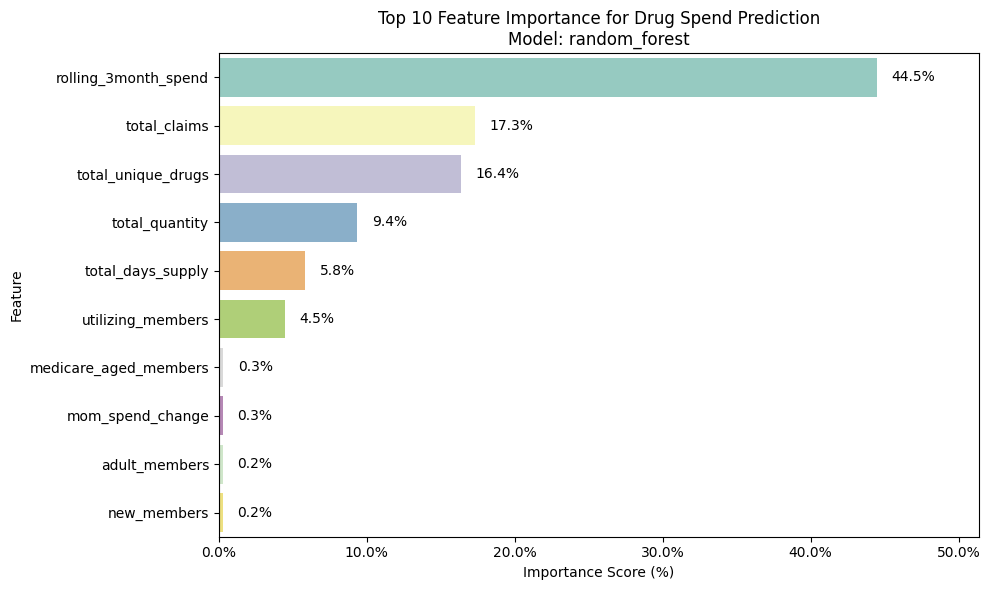

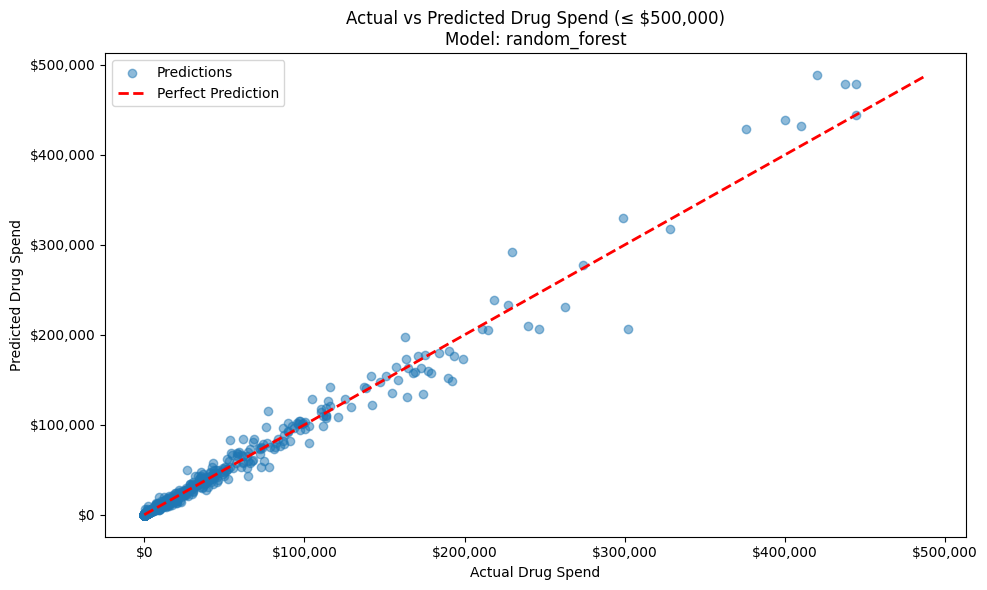

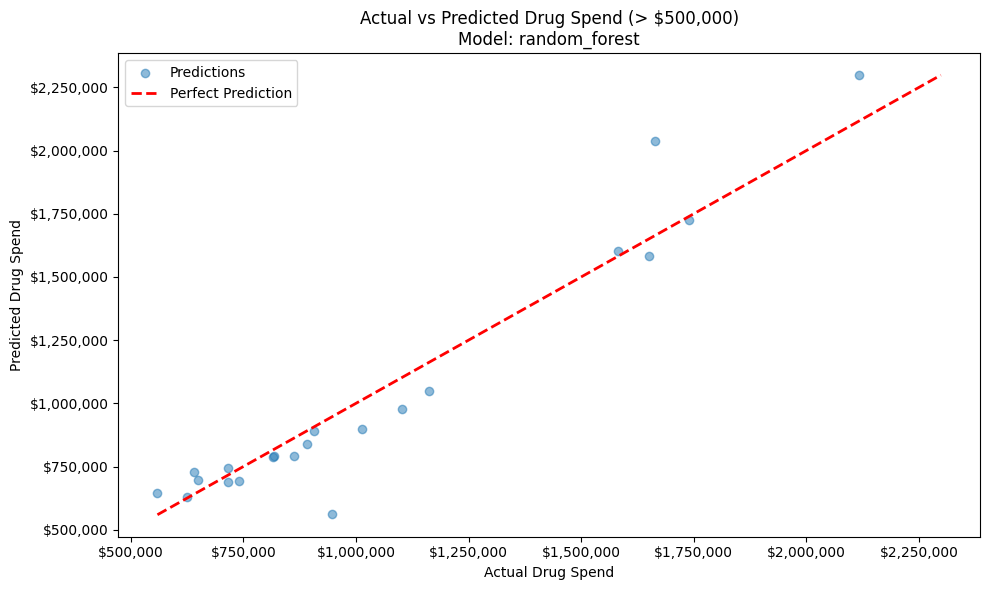

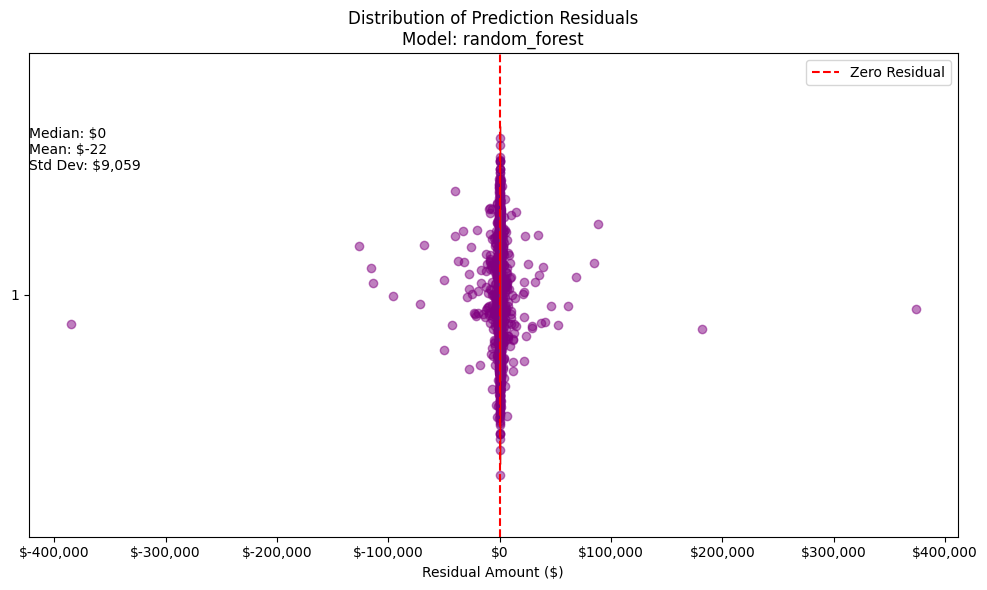

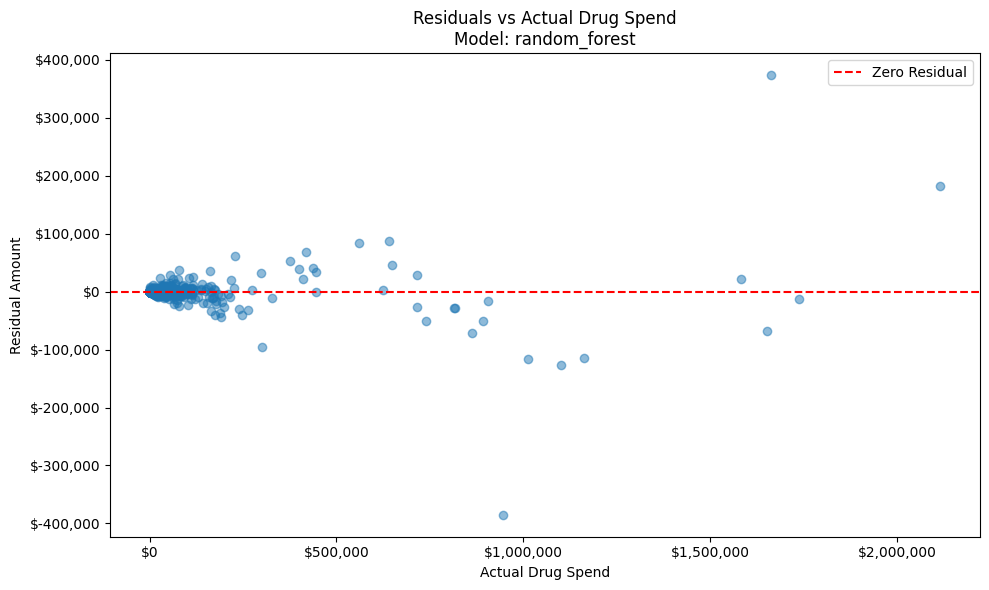

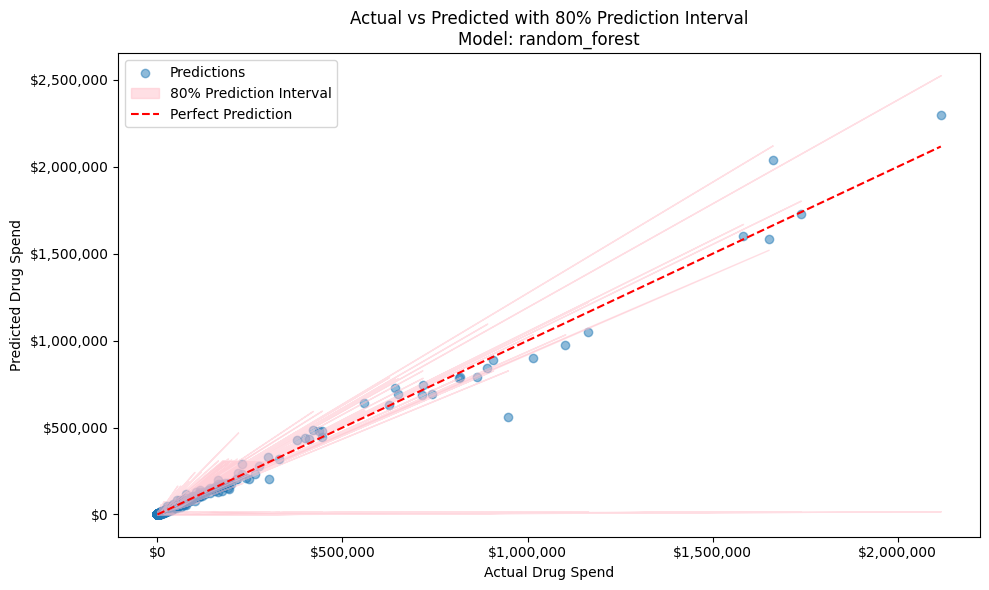


Model Type: lightgbm

Sample of Actual vs Predicted Values:
------------------------------------
 Sample Row # (from test set)     Actual  Predicted
                         2501 $29,178.84 $26,658.93
                        21246      $0.00      $7.69
                        26998      $0.00      $7.69
                        26819      $0.00      $7.69
                        13634    $793.88    $670.30

Value Ranges:
Actual values range: $0.00 to $2,116,728.90
Predicted values range: $-21,719.96 to $2,136,950.70

Overall Model Performance (LightGBM):
-------------------------
MAE: $1,135.70
RMSE: $14,221.17
R2: 96.26%

Performance by Spend Tier (LightGBM):
-------------------------

Low (<$100k):
Number of claims: 5,455
MAE: $343.51
R²: 97.18%

Medium ($100k-$500k):
Number of claims: 65
MAE: $21,632.18
R²: 87.94%

High (>$500k):
Number of claims: 21
MAE: $143,475.70
R²: 73.52%

Bias Metrics (LightGBM):
------------
Mean Bias: $93.94
Percent Over-predicted: 72.6%


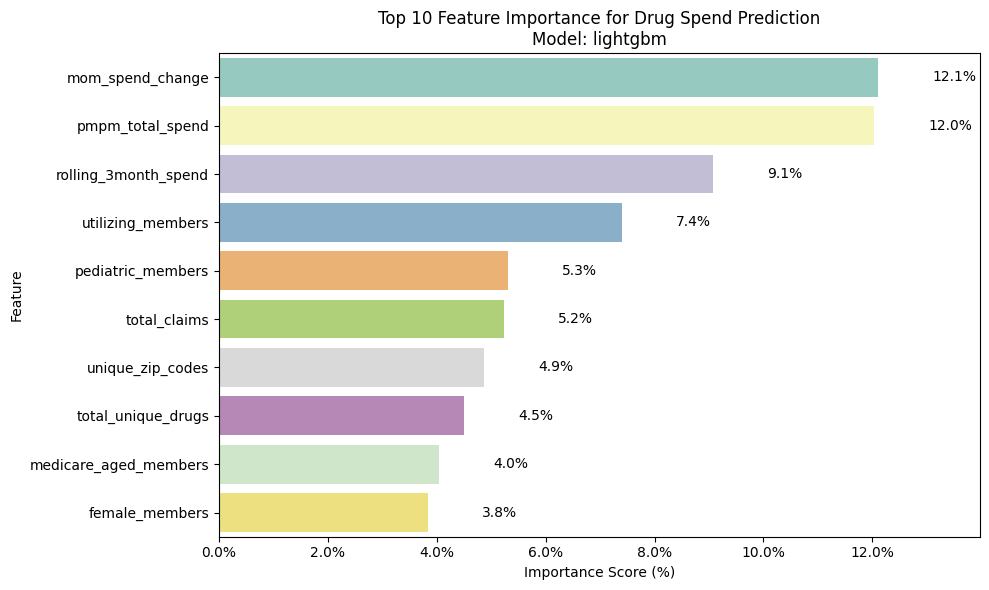

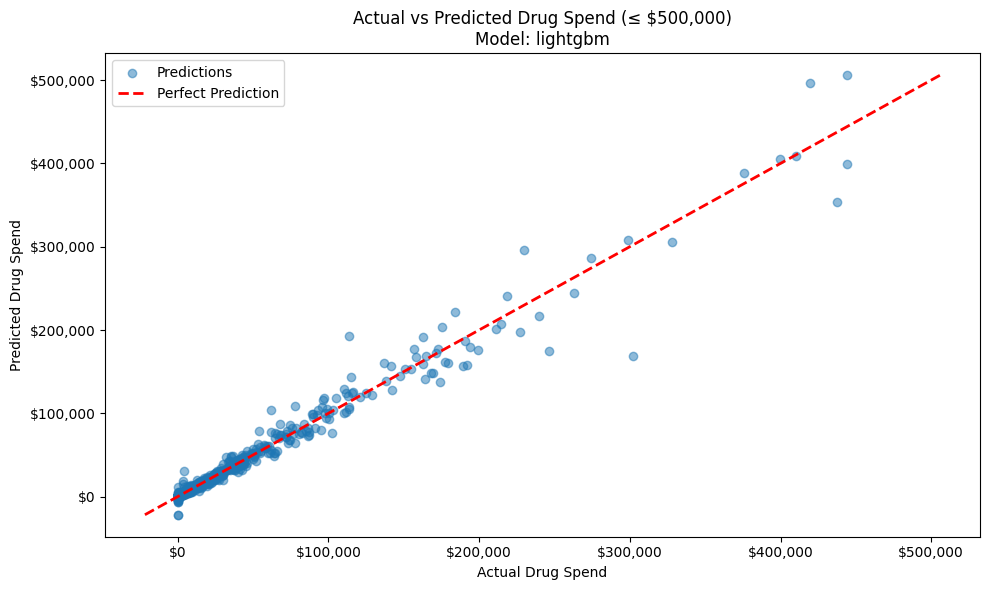

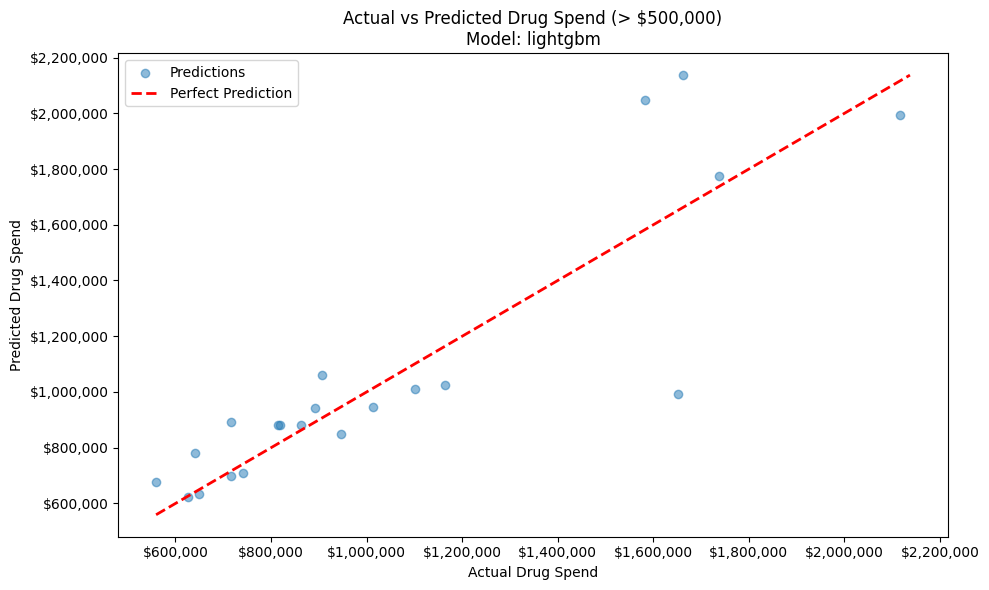

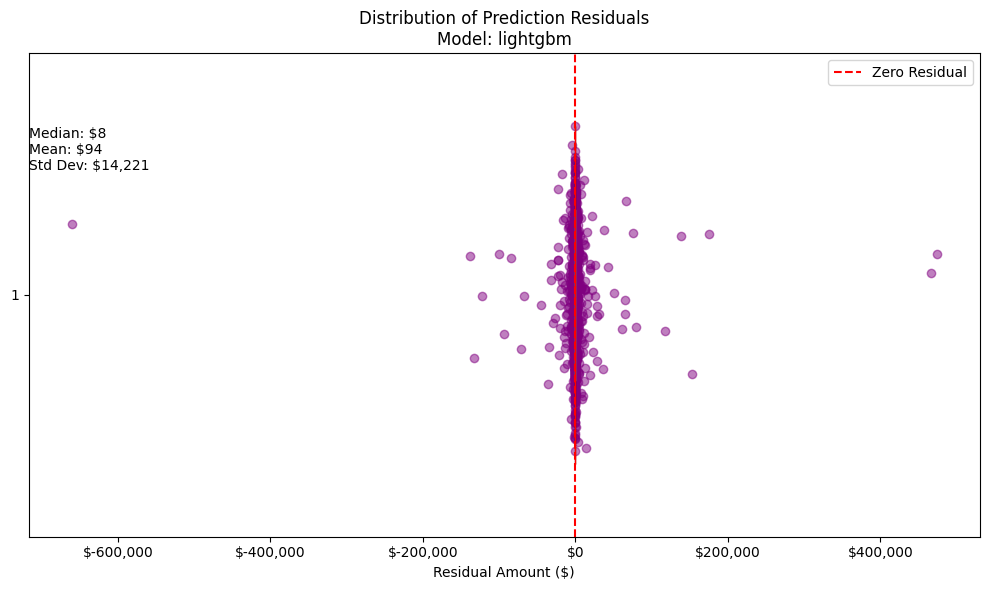

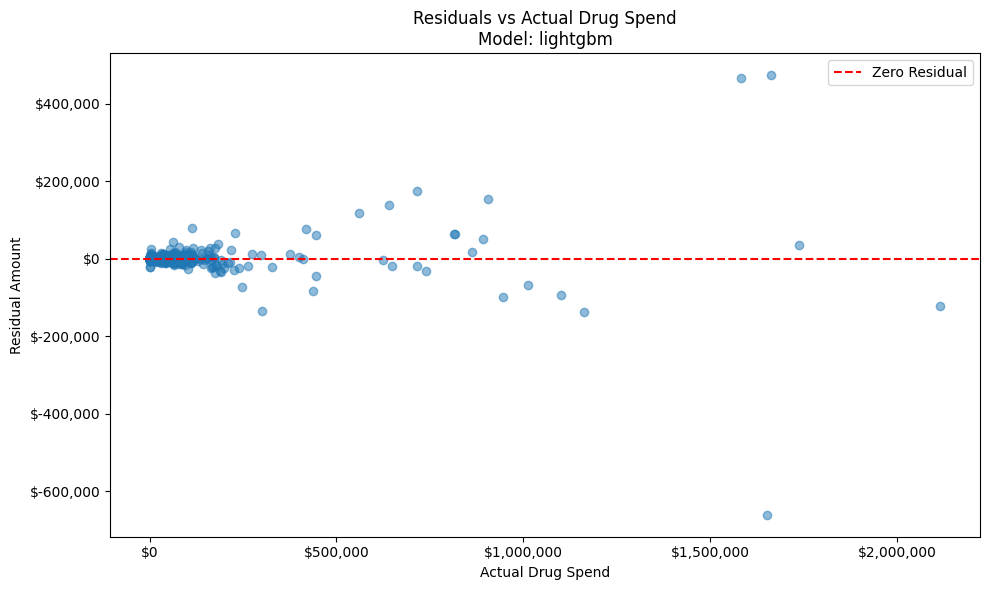

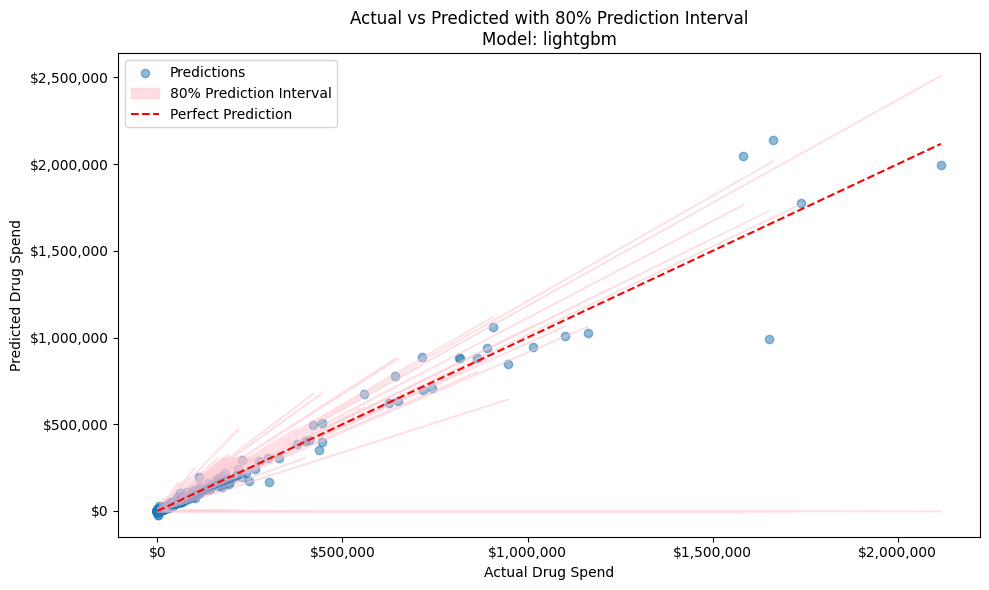


Model Type: random_forest

Sample of Actual vs Predicted Values:
------------------------------------
 Sample Row # (from test set)     Actual  Predicted
                         2501 $29,178.84 $30,222.41
                        21246      $0.00      $0.00
                        26998      $0.00      $0.00
                        26819      $0.00      $0.00
                        13634    $793.88    $773.01

Value Ranges:
Actual values range: $0.00 to $2,116,728.90
Predicted values range: $0.00 to $2,298,622.58

Model Type: lightgbm

Sample of Actual vs Predicted Values:
------------------------------------
 Sample Row # (from test set)     Actual  Predicted
                         2501 $29,178.84 $26,658.93
                        21246      $0.00      $7.69
                        26998      $0.00      $7.69
                        26819      $0.00      $7.69
                        13634    $793.88    $670.30

Value Ranges:
Actual values range: $0.00 to $2,116,728.90
Predicted 

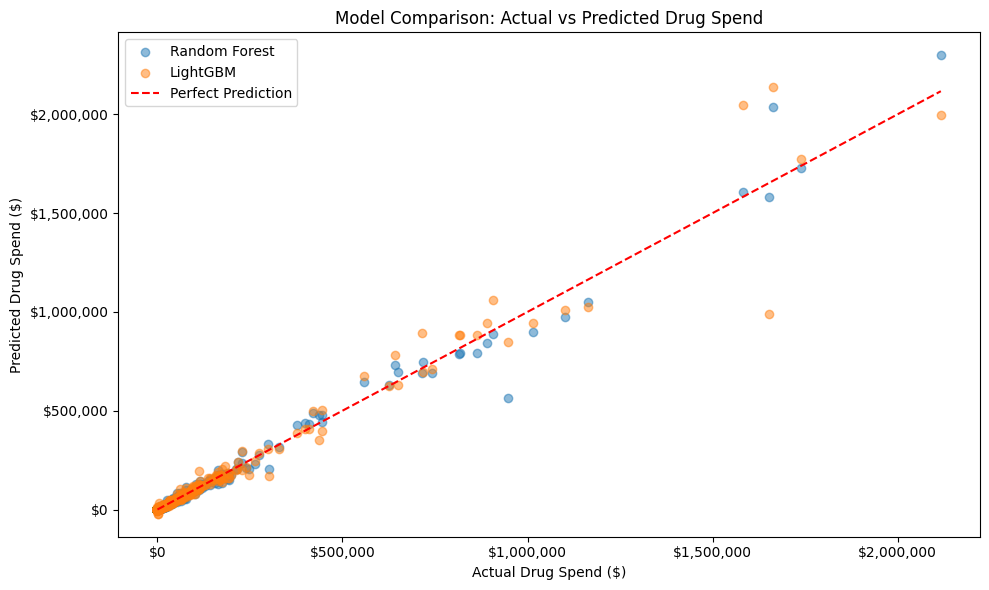

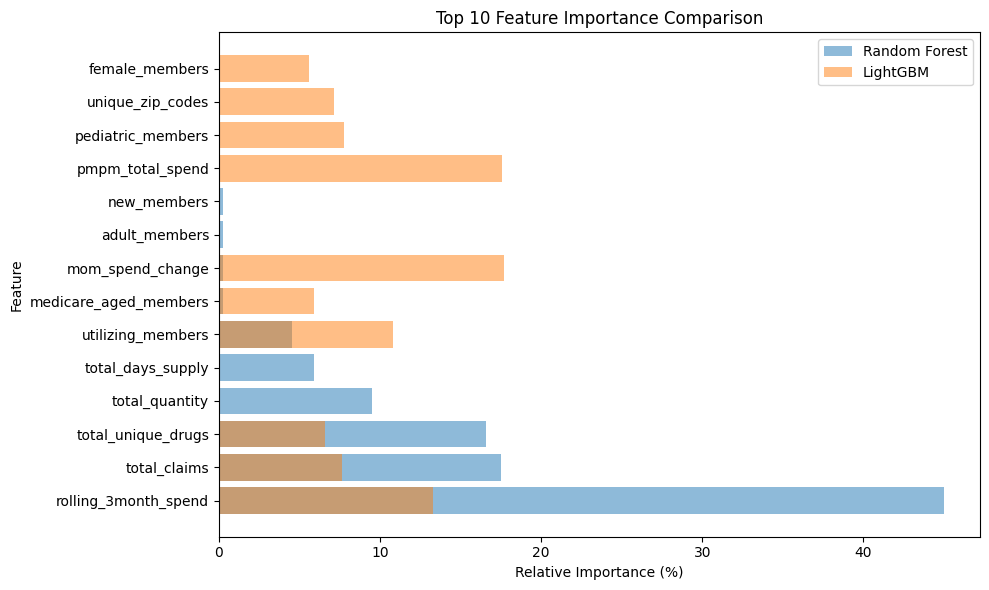

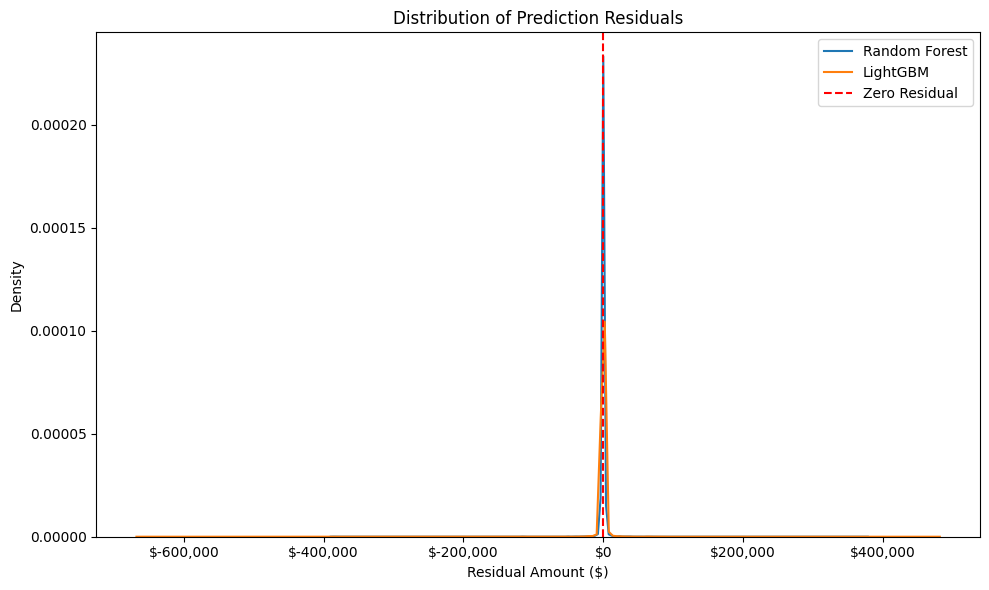

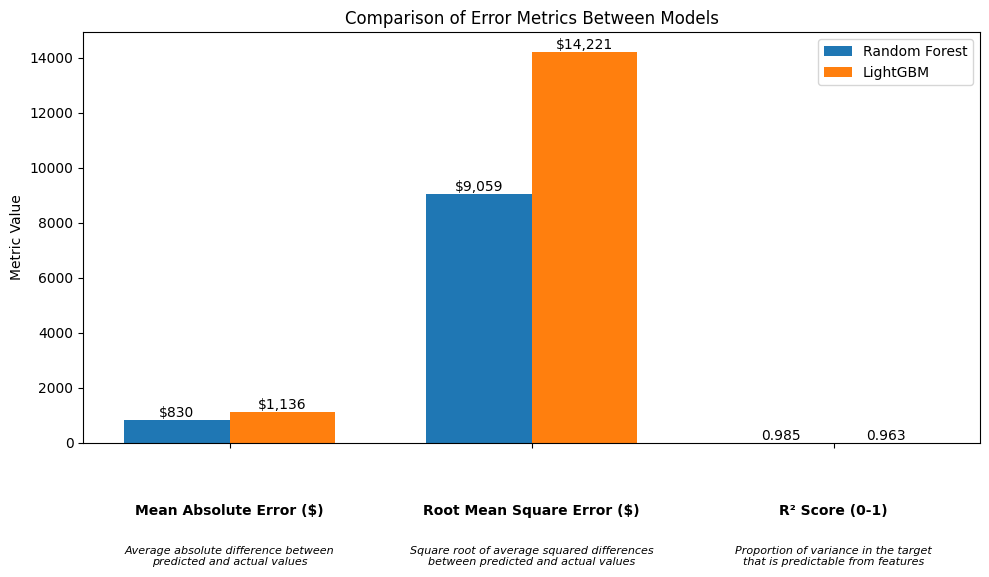

In [85]:
# Load the drug spend data
df = pd.read_csv('data/drug_spend_1.csv')

# ==============================================================
# Use Random Forest model (default)
# ==============================================================
rf_forecaster = DrugSpendForecast(df)
model = rf_forecaster.train_model()

# Get detailed performance metrics
metrics = rf_forecaster.get_detailed_metrics()

# Print overall metrics
print("\nOverall Model Performance (Random Forest):")
print("-------------------------")
for metric, value in metrics['overall_metrics'].items():
    if metric in ['mape', 'r2']:
        print(f"{metric.upper()}: {value:.2%}")
    else:
        print(f"{metric.upper()}: ${value:,.2f}")

# Print performance by spend tier
print("\nPerformance by Spend Tier (Random Forest):")
print("-------------------------")
for tier, tier_metrics in metrics['tier_metrics'].items():
    print(f"\n{tier}:")
    print(f"Number of claims: {tier_metrics['count']:,}")
    print(f"MAE: ${tier_metrics['mae']:,.2f}")
    print(f"R²: {tier_metrics['r2']:.2%}")

# Print bias metrics
print("\nBias Metrics (Random Forest):")
print("------------")
print(f"Mean Bias: ${metrics['bias_metrics']['mean_bias']:,.2f}")
print(f"Percent Over-predicted: {metrics['bias_metrics']['pct_over_predicted']:.1f}%")

# Feature importance plot
rf_forecaster.plot_feature_importance()
plt.show()

# Actual vs Predicted plots (split by spend level)
rf_forecaster.plot_actual_vs_predicted_low_spend()
plt.show()

rf_forecaster.plot_actual_vs_predicted_high_spend()
plt.show()

# Residuals distribution
rf_forecaster.plot_residuals_distribution()
plt.show()

# Residuals by actual spend
rf_forecaster.plot_residuals_by_actual()
plt.show()

# Prediction intervals
rf_forecaster.plot_prediction_intervals()
plt.show()

# ==============================================================
# Use LightGBM model
# ==============================================================
lgb_forecaster = DrugSpendForecast(df, model_type='lightgbm')
model = lgb_forecaster.train_model()

# Get detailed performance metrics
metrics = lgb_forecaster.get_detailed_metrics()

# Print overall metrics
print("\nOverall Model Performance (LightGBM):")
print("-------------------------")
for metric, value in metrics['overall_metrics'].items():
    if metric in ['mape', 'r2']:
        print(f"{metric.upper()}: {value:.2%}")
    else:
        print(f"{metric.upper()}: ${value:,.2f}")

# Print performance by spend tier
print("\nPerformance by Spend Tier (LightGBM):")
print("-------------------------")
for tier, tier_metrics in metrics['tier_metrics'].items():
    print(f"\n{tier}:")
    print(f"Number of claims: {tier_metrics['count']:,}")
    print(f"MAE: ${tier_metrics['mae']:,.2f}")
    print(f"R²: {tier_metrics['r2']:.2%}")

# Print bias metrics
print("\nBias Metrics (LightGBM):")
print("------------")
print(f"Mean Bias: ${metrics['bias_metrics']['mean_bias']:,.2f}")
print(f"Percent Over-predicted: {metrics['bias_metrics']['pct_over_predicted']:.1f}%")

# Feature importance plot
lgb_forecaster.plot_feature_importance()
plt.show()

# Actual vs Predicted plots (split by spend level)
lgb_forecaster.plot_actual_vs_predicted_low_spend()
plt.show()

lgb_forecaster.plot_actual_vs_predicted_high_spend()
plt.show()

# Residuals distribution
lgb_forecaster.plot_residuals_distribution()
plt.show()

# Residuals by actual spend
lgb_forecaster.plot_residuals_by_actual()
plt.show()

# Prediction intervals
lgb_forecaster.plot_prediction_intervals()
plt.show()

# ==============================================================
# Compare both models (Random Forest vs LightGBM)
# ==============================================================
comparison = DrugSpendForecast.compare_models(df)
actual_vs_pred, feature_importance, residuals, error_metrics = DrugSpendForecast.plot_model_comparison(df)

# Show actual vs predicted
actual_vs_pred
plt.show()

# Show feature importance
feature_importance
plt.show()

# Show residuals
residuals
plt.show()

# Show error metrics
error_metrics
plt.show()
